![montage](./montage_mri_final.png)

## Quantitative T1 MRI using Python

## Model: $$ S = Mz * (1 - e^{ (TR / T1 )} )$$

## Objetive: 
- Estimate `T1` and `Mz` for all voxels in the data


## Metadata
- TR (msec) =  508.2336 1000 1500 2500 3500 4500 5500 6500
- Rows = 128
- Cols = 128
- Total images = 168
- Slices = 21  

## Sample:
- Lime

## source:
- Data.World ([@julio](https://data.world/julio/learn-quantitative-mri))




In [1]:
# Modules
import pandas as pd
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define variables
TR = [508.2336 ,1000 ,1500 ,2500 ,3500 ,4500 ,5500 ,6500];
TR = np.array(TR)/1000;
Total_Slices = 21

In [3]:
# load data
cut_trough_lime = 10;
#matrix
MRI_2D = pd.read_csv('T1Lemon.csv',header=None).values[:,1::];

In [4]:
# use it to normalize data
def normalize_images(DataMatrix, Slice):
    new_index = Slice - 1 
    Normalized_Data = DataMatrix[:,new_index:168:21 ]
    Normalized_Data = Normalized_Data / np.max(Normalized_Data.flatten())
    return Normalized_Data

# montage function to show data    
def montage(DataMatrix, Slice, xdata, cmap = 'nipy_spectral'):
    I = normalize_images(DataMatrix, Slice)
    for i in range(8):
        A = I[:,i].reshape((128,128))
        plt.subplot(2,4,i+1)
        plt.imshow(  A, vmin = 0.0,vmax=1.1, cmap = cmap)
        plt.title('TR =' + str(  round(xdata[i],2)))

# plot average signal
def plot_slice(DataMatrix, Slice, xdata):
    I = normalize_images(DataMatrix, Slice)
    I = normalize_images(MRI_2D, 1)
    plt.plot(xdata, np.mean(I, axis = 0),'o-')
    plt.title('Signal evolution')
    plt.xlabel('Time (sec)')
    plt.ylabel('signal')

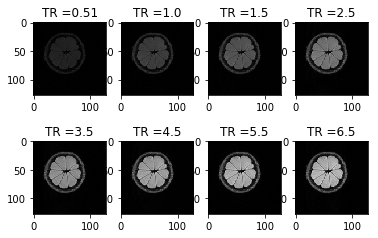

In [5]:
#image montage
Slice = 21
montage(MRI_2D,Slice, TR, cmap ='gray')

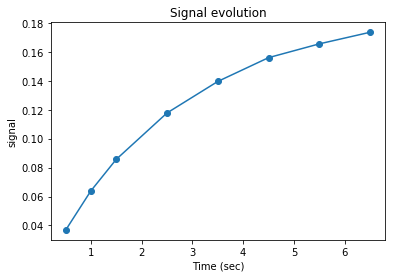

In [6]:
plot_slice(MRI_2D, Slice, TR)

## T1 map for all voxels in a singel slice

In [7]:
from scipy.optimize import curve_fit
import numpy as np

#model
def t1_time(x_,*pars):
    return pars[0] * (1 - np.exp(-x_ / pars[1]))

# fitting for a voxel
def fit_t1_time(signal):
    signal = signal / np.max(signal)
    #fit
    fitted_pars, cov= curve_fit(t1_time, TR, signal, p0 = [1. , 2], maxfev = 1000)
    return fitted_pars[1]

# fitting for the entire 3D image
def T1map(DataMatrix, Slice):
    # extract sllices
    I = DataMatrix [:, Slice:168:21]
    
    # number of voxels
    voxels, _ = I.shape

    # create filter
    SNR = I[:,0] / np.std(DataMatrix[0,:])

    # preallocate
    T1 = np.zeros_like(SNR)
    T1[SNR <20] = 0
    
    # map function
    predicted_T1 = map(fit_t1_time, list(I[SNR > 20, :]))
    predicted_T1 = np.array( list(predicted_T1) )
    
    # output
    T1[SNR > 20] = predicted_T1
    
    return T1.reshape((128,128))

In [8]:
%%time
map_T1 = T1map(MRI_2D, 1)

/Users/Julio/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp
/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CPU times: user 4.12 s, sys: 43.5 ms, total: 4.17 s
Wall time: 4.17 s


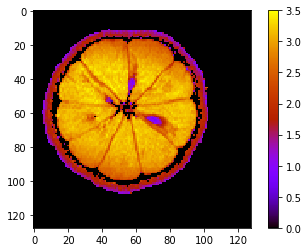

In [9]:
plt.imshow(map_T1, cmap ='gnuplot', vmin = 0, vmax= 3.5); plt.colorbar();

In [11]:
def T1map_V2(DataMatrix, Slice):
    # extract sllices
    I = DataMatrix [:, Slice:168:21]
    
    # number of voxels
    voxels, _ = I.shape

    # preallocate
    T1 = np.zeros((voxels,1))
    
    # Loop function
    for idx, signal in enumerate(I):
        T1[idx] = fit_t1_time(signal)
            
    return T1.reshape((128,128))

In [13]:
%%time
map_T1 = T1map_V2(MRI_2D, 1);

/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Julio/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


CPU times: user 11.7 s, sys: 21.7 ms, total: 11.7 s
Wall time: 11.7 s


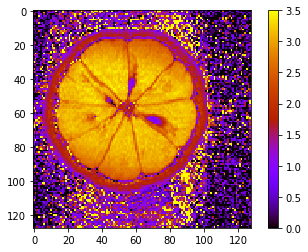

In [14]:
plt.imshow(map_T1, cmap ='gnuplot', vmin = 0, vmax= 3.5); plt.colorbar();